<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/gridsearch_model_scaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# overview

Uses actions and an input state to predict the output state.

# imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import math
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras import metrics

2.0.0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5299293262610674563
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11765783648112272085
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3110559376267011595
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18199493840907851773
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# mount drive

In [0]:
file = 'dataset_all_01.csv'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
working dir: /content/drive/My Drive/xplane_data


# load and prepare data

## define features (actions & states)
actions and states at time t are the input for the network.

the states at time t + 1 are the desired output of the network.


In [6]:
col_m_time      = '   missn,_time '
col_t_time      = '   _totl,_time '
col_yaw_v       = '   ____Q,rad/s '

col_yaw_deg     = '   _beta,__deg '
col_roll_deg    = '   _roll,__deg '
col_roll_v      = '   ____R,rad/s '
col_pitch_deg   = '   pitch,__deg '
col_pitch_v     = '   ____P,rad/s '
col_alt         = '   __alt,ftmsl '
col_vv          = '   __VVI,__fpm '
col_v           = '   Vtrue,_ktas '
col_rpm_prop    = '   rpm_1,_prop '
col_throttle     = '   thro1,_part '

cols_state = [ 
    col_yaw_v,
    col_yaw_deg,
    col_roll_deg,
    col_roll_v,
    col_pitch_deg,
    col_pitch_v,
    col_vv,
    col_alt,
    col_v,
    col_rpm_prop,
    col_throttle,
]

cols_time = [
    col_m_time,
    col_t_time,
]

col_elev_servo                  = '   _elev,servo '
col_ailrn_servo                  = '   ailrn,servo '
col_ruddr_servo                  = '   ruddr,servo '

cols_action = [
    col_elev_servo,
    col_ailrn_servo,
    col_ruddr_servo
]

# all input columns
cols_features = []
cols_features.extend(cols_state)
cols_features.extend(cols_action)

# orga column
col_dataset_index = 'dataset_index'
col_maneuver_index = 'maneuver_index'
col_maneuver_name = 'maneuver_name'
col_maneuver_datapoint_index = 'maneuver_datapoint_index'
col_maneuver_type = 'maneuver_type'


label_prefix = 't+1_'
cols_label = [label_prefix + col_state for col_state in cols_state]
print(cols_label)


['t+1_   ____Q,rad/s ', 't+1_   _beta,__deg ', 't+1_   _roll,__deg ', 't+1_   ____R,rad/s ', 't+1_   pitch,__deg ', 't+1_   ____P,rad/s ', 't+1_   __VVI,__fpm ', 't+1_   __alt,ftmsl ', 't+1_   Vtrue,_ktas ', 't+1_   rpm_1,_prop ', 't+1_   thro1,_part ']


## load data

In [7]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter=',', usecols = columns, 
                       float_precision='high')

df_features = load_xplane_csv(file, cols_features)

df_labels = load_xplane_csv(file, cols_label)

print(len(df_features))
print(len(df_labels))
assert(len(df_features) == len(df_labels))


477893
477893


## drop nan in features and labels

drop nan rows in both features and in labels

In [8]:
df_nan = df_labels.isna().any(axis=1)

for i in range(0, len(df_nan)):
  if df_nan[i] == True:
    df_features.drop(index=i, inplace=True)

df_labels.dropna(inplace=True)

print(len(df_features))
print(len(df_labels))

477290
477290


In [0]:
def split_train_test(dataset):
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test


## split data

In [0]:
features = df_features.values
labels = df_labels.values

In [0]:
train_X, test_X, train_Y, test_Y  = train_test_split(features,labels, test_size=0.2, random_state=42)

In [12]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(381832, 14)
(381832, 11)
(95458, 14)
(95458, 11)


## scale data

In [0]:
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_X)

train_X = feature_scaler.transform(train_X)
test_X = feature_scaler.transform(test_X)


In [0]:
label_scaler = MinMaxScaler()
label_scaler.fit(train_Y)

train_Y = label_scaler.transform(train_Y)
test_Y = label_scaler.transform(test_Y)

In [0]:
# create scaled df
scaled_df_features = pd.DataFrame(feature_scaler.transform(df_features), columns=df_features.columns)
scaled_df_labels = pd.DataFrame(label_scaler.transform(df_labels), columns=df_labels.columns)

In [16]:
df_features.describe()

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.0
mean,119.567353,31.868167,0.003814,-0.000023,-0.001840,-0.653563,-0.791051,0.006402,2714.494715,0.837601,2490.420838,-0.000023,-0.014557,0.0
std,10.113279,274.992679,0.007108,0.017348,0.023905,1.684671,8.876412,0.137679,1357.480837,0.082115,127.216137,0.002304,0.022662,0.0
min,66.424780,-1917.888180,-0.039450,-0.109810,-0.054820,-9.313510,-23.851520,-0.689970,805.092900,0.796080,2106.257810,-0.089790,-0.159740,0.0
25%,116.120002,-38.766265,-0.000010,-0.000410,-0.010880,-1.284538,-4.070882,-0.082300,1411.464812,0.796080,2424.051882,-0.000110,-0.017030,0.0
50%,118.825780,0.342395,0.001120,-0.000000,-0.000020,-0.787040,-0.104720,0.004390,2622.403565,0.796080,2458.394655,0.000000,-0.015220,0.0
75%,122.744895,165.376283,0.010170,0.000390,0.000847,-0.151363,0.212638,0.073260,3896.206053,0.796080,2504.543460,0.000070,-0.011370,0.0
max,155.436650,978.538330,0.041650,0.111310,0.055400,11.796170,25.924920,0.353550,5080.888180,1.000000,2811.808840,0.045100,0.124900,0.0


In [17]:
scaled_df_features.describe()

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,4.772900e+05,477290.000000,477290.000000,477290.000000,477290.000000,477290.0
mean,0.597028,0.673159,0.533466,0.496506,0.480678,0.410273,0.463281,0.667330,4.465606e-01,0.203613,0.544487,0.665484,0.510059,0.0
std,0.113617,0.094942,0.087647,0.078456,0.216880,0.079813,0.178326,0.131938,3.174807e-01,0.402681,0.180307,0.017080,0.079616,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.566223e-07,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.558299,0.648773,0.486313,0.494754,0.398657,0.380380,0.397390,0.582327,1.418146e-01,0.000000,0.450420,0.664838,0.501370,0.0
50%,0.588697,0.662275,0.500247,0.496608,0.497187,0.403949,0.477069,0.665402,4.250228e-01,0.000000,0.499095,0.665653,0.507729,0.0
75%,0.632726,0.719253,0.611837,0.498372,0.505058,0.434065,0.483445,0.731399,7.229333e-01,0.000000,0.564503,0.666172,0.521255,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000090,1.000000,1.000000,1.000001e+00,1.000000,1.000000,1.000000,1.000000,0.0


In [18]:
df_labels.describe()

,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.003815,0.006402,-0.791050,-0.001840,-0.653565,-0.000023,31.866864,2714.494657,119.567394,2490.421446,0.837601
std,0.007105,0.137680,8.876411,0.023905,1.684673,0.017348,274.991234,1357.480898,10.113312,127.216670,0.082115
min,-0.038680,-0.689970,-23.851520,-0.054820,-9.313510,-0.109810,-1917.888180,805.092900,66.424780,2106.257810,0.796080
25%,-0.000010,-0.082300,-4.070882,-0.010888,-1.284488,-0.000410,-38.766265,1411.464812,116.120015,2424.051882,0.796080
50%,0.001120,0.004390,-0.104720,-0.000020,-0.787045,0.000000,0.342395,2622.403565,118.825780,2458.394900,0.796080
75%,0.010160,0.073260,0.212860,0.000850,-0.151363,0.000390,165.372623,3896.206053,122.745007,2504.543950,0.796080
max,0.041650,0.353550,25.924920,0.055400,11.796170,0.111310,978.538330,5080.888180,155.436650,2811.808840,1.000000


In [19]:
scaled_df_labels.describe()

,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.529000,0.667368,0.463281,0.480678,0.410236,0.496619,0.673159,0.446561,0.597028,0.544487,0.203615
std,0.088447,0.131945,0.178326,0.216880,0.079806,0.078474,0.094942,0.317480,0.113618,0.180308,0.402682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.481389,0.582361,0.397390,0.398589,0.380348,0.494866,0.648773,0.141815,0.558299,0.450420,0.000000
50%,0.495456,0.665440,0.477069,0.497187,0.403913,0.496720,0.662275,0.425023,0.588697,0.499095,0.000000
75%,0.607992,0.731442,0.483449,0.505081,0.434026,0.498485,0.719252,0.722933,0.632727,0.564504,0.000000
max,1.000000,1.000058,1.000000,1.000000,1.000000,1.000226,1.000000,1.000000,1.000000,1.000000,1.000000


# train models

## define callbacks functions

In [0]:
def prepare_tensorboard_callback(model_name=''):
  logs_base_dir = "./tensorbaord_logs"
  model_log_dir = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
  target_log_dir = os.path.join(logs_base_dir, model_log_dir)
  os.makedirs(target_log_dir, exist_ok=True)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(target_log_dir, histogram_freq=1)
  return tensorboard_callback


In [0]:
def prepare_checkpoint_callback(model_name):
  checkpoint_base_dir = './checkpoints'
  os.makedirs(checkpoint_base_dir, exist_ok=True)
  filepath = os.path.join(checkpoint_base_dir, 'cp_'+ model_name)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                  save_weights_only=True,
                                                  verbose=1)
  return cp_callback 

## define plot_and_save functions

In [22]:
base_folder = './results'
notebook_folder = 'gridsearch_model_scaled'
results_folder = os.path.join(base_folder, notebook_folder)
os.makedirs(results_folder, exist_ok=True)
print('results_folder : ', results_folder)

saved_model_weight = 'saved_weights'
saved_model_weight_path = os.path.join(results_folder, saved_model_weight)
os.makedirs(saved_model_weight_path, exist_ok=True)


results_folder :  ./results/gridsearch_model_scaled


### loss historie

In [0]:
def save_plots_before_show(diagramm_name):
  if not os.path.exists(results_folder):
      os.makedirs(diagramm_folder)

  plt.savefig(results_folder + '/' + diagramm_name +'.pdf')
  plt.savefig(results_folder + '/' + diagramm_name +'.svg')
  plt.savefig(results_folder + '/' + diagramm_name +'.png')

def pas_history(model_tupels, histories, key='mean_squared_error'):
  model_names = [model_tupel[0] for model_tupel in model_tupels]
  plt.figure(figsize=(16,10))
  for i, history in enumerate(histories):
    history_epoch= range(0, len(history['loss']) )

    val = plt.plot(history_epoch, history['val_'+key],
                   '--', label=model_names[i]+' Val')
    plt.plot(history_epoch, history[key], color=val[0].get_color(),
             label=model_names[i]+' Train')

  plt.xlabel('Epochs')
  plt.yscale("log")
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history_epoch)])
  save_plots_before_show('history_loss'+'_'+key)
  plt.show()

### metrics (overall and for all single targets )



In [0]:
def pas_metrics_scaled(model_tupel):
  model_name = model_tupel[0]
  model = model_tupel[1]
  df = _df_prediction_metrics(model, scaled=True)
  file_path = os.path.join(results_folder, model_name + '_scaled.csv')
  df.to_csv(path_or_buf=file_path)
  return df
  
def pas_metrics(model_tupel):
  model_name = model_tupel[0]
  model = model_tupel[1]
  df = _df_prediction_metrics(model, scaled=False)
  file_path = os.path.join(results_folder, model_name + '.csv')
  df.to_csv(path_or_buf=file_path)
  return df


def _df_prediction_metrics(model, scaled):
  '''
  creates describe dataframe of labels and 
  connect them with mse,rmse and mae per target and overall 
  '''
  pred_Y = model.predict(test_X)
  
  if scaled:
    labels = scaled_df_labels
    truth_Y = test_Y
  else:
    labels = df_labels
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)


  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  rmses = np.array([math.sqrt(mse) for mse in mses])
  maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_describe = labels.describe()
  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=['mses'],     # index
            columns=labels.columns)  #  column names
  df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
        index=['rmes'],     # index
        columns=labels.columns)  #  column names
  df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
        index=['maes'],     # index
        columns=labels.columns)  #  column names
  
  
  df_mse_all = pd.DataFrame(data=mse,    # values
            index=['mse'],     # index
            columns=labels.columns)  #  column names
  df_rmse_all = pd.DataFrame(data=rmse,    # values
        index=['rme'],     # index
        columns=labels.columns)  #  column names
  df_mae_all = pd.DataFrame(data=mae,    # values
        index=['mae'],     # index
        columns=labels.columns)  #  column names
  

  metrics = [df_mse_per_feature, df_rmse_per_feature, df_mae_per_feature, 
             df_mse_all,df_rmse_all,df_mae_all]
  return df_describe.append(metrics)

## define models

In [0]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]

def create_model(model_name, layers, keras_activation, kernel_initializer, 
                 loss, metrics):
  if not layers:
    raise Exception('No layers defined. Expected in format [100,100]') 

  model = keras.Sequential(name=model_name)
  
  model.add(Dense(layers[0],input_shape=(features_nr,), 
                          kernel_initializer=kernel_initializer))
  model.add(keras_activation())

  for i in range(1, len(layers)):
    layer_val = layers[i]
    model.add(Dense(layer_val, kernel_initializer=kernel_initializer))
    model.add(keras_activation())

  model.add(Dense(target_nr ))

  model.compile(optimizer='adam',
                        loss=loss,
                        metrics=metrics)

  model.summary()
  print(model.to_json())
  return (model_name, model)


In [26]:
keras_activation = ReLU
kernel_initializer='he_uniform'
loss='mean_squared_error',
metrics=['mean_squared_error', 'mean_absolute_error']


model1 = create_model('model1', [400, 400], keras_activation, kernel_initializer, 
             loss, metrics)

model2 = create_model('model2', [200, 200], keras_activation, kernel_initializer, 
             loss, metrics)


model3 = create_model('model3', [100, 100], keras_activation, kernel_initializer, 
             loss, metrics)

model4 = create_model('model4', [200], keras_activation, kernel_initializer, 
             loss, metrics)


models = [model1, model2, model3, model4]

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               6000      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                4411      
Total params: 170,811
Trainable params: 170,811
Non-trainable params: 0
_________________________________________________________________
{"class_name": "Sequential", "config": {"name": "model1", "layers": [{"class_name": "Dense", "config": {"name": "dense",

## train, save and load model

In [0]:
def train_model(model_tupel, epochs, batch_size):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  callbacks = [
              #prepare_checkpoint_callback(model_name=model_name),
              prepare_tensorboard_callback(model_name=model_name)
              ]

  history = keras_model.fit(train_X,
                            train_Y,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(test_X, test_Y),
                            verbose=2,
                            callbacks=callbacks
                            )
  return history  

def _format_model_path(model_name):
  file_name = '{}_end'.format(model_name)
  return os.path.join(saved_model_weight_path, file_name)

def save_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  keras_model.save_weights(file_path)

def load_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  exact_file_path = file_path + '.index'
  if os.path.isfile(exact_file_path):
    print('load model {}'.format(model_name))
    keras_model.load_weights(file_path)
    return True
  else:
    return False

def _format_history_path(model_name):
  file_name = '{}_history_dict'.format(model_name)
  return os.path.join(results_folder, file_name)
  

def save_history(model_tupel, history):
  file_path = _format_history_path(model_tupel[0])
  with open(file_path, 'wb') as file_hist:
        pickle.dump(history.history, file_hist)
  

def load_history(model_tupel):
  file_path = _format_history_path(model_tupel[0])
  if not os.path.isfile(file_path):
    return dict()
  with open(file_path, 'rb') as file_hist:
    return pickle.load(file_hist)

In [29]:
histories = []
for model in models:
  if not load_model(model):
    print(model[0])
    history = train_model(model, epochs=10, batch_size=32)
    save_model(model)
    save_history(model, history)
    histories.append(history.history)
    print('*******************')
  else:
    history = load_history(model)
    histories.append(history)

model1
Train on 381832 samples, validate on 95458 samples
Epoch 1/10
381832/381832 - 56s - loss: 2.7677e-06 - mean_squared_error: 2.7677e-06 - mean_absolute_error: 0.0010 - val_loss: 4.3490e-06 - val_mean_squared_error: 4.3490e-06 - val_mean_absolute_error: 0.0016
Epoch 2/10
381832/381832 - 56s - loss: 2.8787e-06 - mean_squared_error: 2.8787e-06 - mean_absolute_error: 0.0010 - val_loss: 3.1384e-06 - val_mean_squared_error: 3.1384e-06 - val_mean_absolute_error: 0.0012
Epoch 3/10
381832/381832 - 56s - loss: 2.7702e-06 - mean_squared_error: 2.7702e-06 - mean_absolute_error: 9.9222e-04 - val_loss: 2.2048e-06 - val_mean_squared_error: 2.2048e-06 - val_mean_absolute_error: 9.2239e-04
Epoch 4/10
381832/381832 - 56s - loss: 2.6650e-06 - mean_squared_error: 2.6650e-06 - mean_absolute_error: 9.8217e-04 - val_loss: 2.2484e-06 - val_mean_squared_error: 2.2484e-06 - val_mean_absolute_error: 9.0138e-04
Epoch 5/10
381832/381832 - 56s - loss: 2.7100e-06 - mean_squared_error: 2.7101e-06 - mean_absolute

## visualize

### Test & Training Loss

In [30]:
for i, history in enumerate(histories):
  last_loss = history['loss'][-1]
  last_val_loss = history['val_loss'][-1]
  model_name = models[i][0]
  print('{} model last loss: {}'.format(model_name,last_loss))
  print('{} model last val loss: {}'.format(model_name,last_val_loss))
  print('*******')

model1 model last loss: 2.511526923562726e-06
model1 model last val loss: 1.724075451628941e-06
*******
model2 model last loss: 4.128292949851825e-06
model2 model last val loss: 4.878468452858382e-06
*******
model3 model last loss: 3.6636337901715974e-06
model3 model last val loss: 2.587691262992593e-06
*******
model4 model last loss: 4.982668848558092e-06
model4 model last val loss: 4.601870442990998e-06
*******


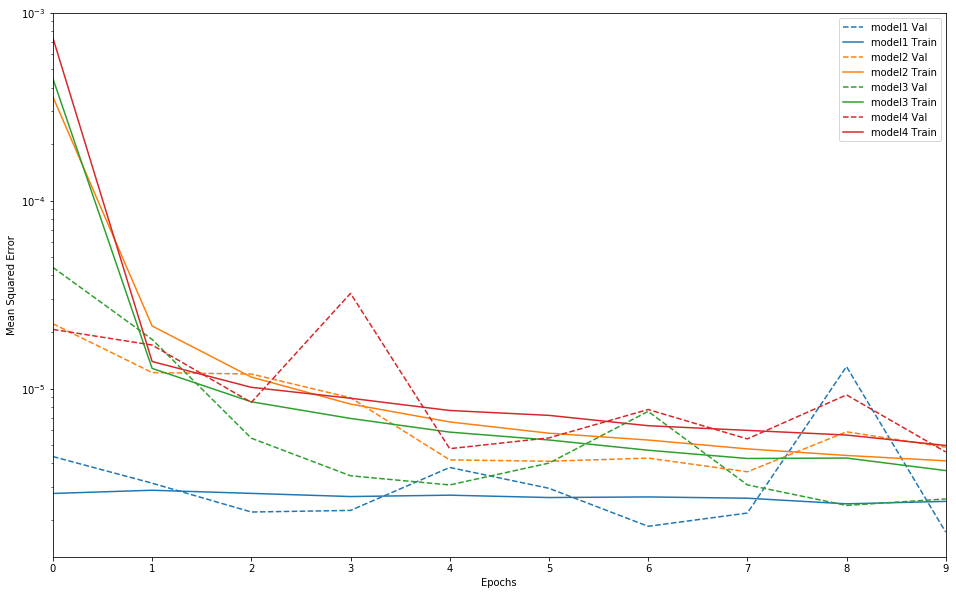

In [31]:
pas_history(models, histories=histories)


### MSE per target (scaled)

In [36]:
for model_tupel in models:
  df = pas_metrics_scaled(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                         'display.width', 1000): 
    print(df)
  print('*********************************************************')

model1
       t+1_   ____Q,rad/s   t+1_   _beta,__deg   t+1_   _roll,__deg   t+1_   ____R,rad/s   t+1_   pitch,__deg   t+1_   ____P,rad/s   t+1_   __VVI,__fpm   t+1_   __alt,ftmsl   t+1_   Vtrue,_ktas   t+1_   rpm_1,_prop   t+1_   thro1,_part 
count        477290.000000         4.772900e+05         4.772900e+05         4.772900e+05        477290.000000        477290.000000         4.772900e+05        477290.000000         4.772900e+05         4.772900e+05         4.772900e+05
mean              0.529000         6.673681e-01         4.632808e-01         4.806785e-01             0.410236             0.496619         6.731588e-01             0.446561         5.970284e-01         5.444874e-01         2.036155e-01
std               0.088447         1.319452e-01         1.783255e-01         2.168802e-01             0.079806             0.078474         9.494155e-02             0.317480         1.136176e-01         1.803082e-01         4.026823e-01
min               0.000000         0.000000e+

### MSE per target (unscaled)

In [35]:
for mode_tupel in models:
  df = pas_metrics(mode_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.width', 1000):  
    print(df)
  print('*********************************************************')

model1
       t+1_   ____Q,rad/s   t+1_   _beta,__deg   t+1_   _roll,__deg   t+1_   ____R,rad/s   t+1_   pitch,__deg   t+1_   ____P,rad/s   t+1_   __VVI,__fpm   t+1_   __alt,ftmsl   t+1_   Vtrue,_ktas   t+1_   rpm_1,_prop   t+1_   thro1,_part 
count         4.772900e+05         4.772900e+05        477290.000000         4.772900e+05        477290.000000         4.772900e+05        477290.000000        477290.000000        477290.000000        477290.000000         4.772900e+05
mean          3.814590e-03         6.401959e-03            -0.791050        -1.839620e-03            -0.653565        -2.251091e-05            31.866864          2714.494657           119.567394          2490.421446         8.376013e-01
std           7.104948e-03         1.376795e-01             8.876411         2.390454e-02             1.684673         1.734834e-02           274.991234          1357.480898            10.113312           127.216670         8.211498e-02
min          -3.868000e-02        -6.899700e-